## CESM2 - LARGE ENSEMBLE (LENS2)

#### by Mauricio Rocha and Dr. Gustavo Marques

- This notebooks servers as an example on how to extract surface (or any other 2D spatial field) properties from a selected spacial region accross all LENS2 members for the ocean component for the historical period.

## Imports

In [1]:
import intake
import intake_esm
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import fsspec
import cmocean
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import pop_tools
import sys
from distributed import Client
from ncar_jobqueue import NCARCluster
sys.path.append('../functions')
import util
from cartopy.util import add_cyclic_point
from misc import get_ij
import warnings, getpass, os

ERROR 1: PROJ: proj_create_from_database: Open of /glade/u/apps/opt/conda/envs/npl-2022b/share/proj failed


<div class="alert alert-block alert-info">
<b>Note:</b> comment the following line when debugging
</div>

In [2]:
warnings.filterwarnings("ignore")

### Local functions

In [3]:
def rms_da(da, dims=('nlat', 'nlon'), weights=None,  weights_sum=None):
  """
  Calculates the rms in DataArray da (optional weighted rms).

  ----------
  da : xarray.DataArray
        DataArray for which to compute (weighted) rms.

  dims : tuple, str
    Dimension(s) over which to apply reduction. Default is ('yh', 'xh').

  weights : xarray.DataArray, optional
    weights to apply. It can be a masked array.

  weights_sum : xarray.DataArray, optional
    Total weight (i.e., weights.sum()). Only computed if not provided.

  Returns
  -------
  reduction : DataSet
      xarray.Dataset with (optionally weighted) rms for da.
  """

  if weights is not None:
    if weights_sum is None: weights_sum = weights.sum(dim=dims)
    out = np.sqrt((da**2 * weights).sum(dim=dims)/weights_sum)
    # copy attrs
    out.attrs = da.attrs
    return out
  else:
    return np.sqrt((da**2).mean(dim=dims, keep_attrs=True))

### Dask workers

In [4]:
mem_per_worker = 160 # in GB 
num_workers = 80 
cluster = NCARCluster(cores=4, processes=3, memory=f'{mem_per_worker} GB',resource_spec=f'select=1:ncpus=6:mem={mem_per_worker}GB')
cluster.scale(num_workers)
client = Client(cluster)
print(client)
client

<Client: 'tcp://10.12.206.39:34820' processes=0 threads=0, memory=0 B>


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mauricio/mrocha/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mauricio/mrocha/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.39:34820,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/mauricio/mrocha/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Data Ingest

In [6]:
%%time
catalog = intake.open_esm_datastore(
    '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'
)

CPU times: user 27.3 s, sys: 1.65 s, total: 28.9 s
Wall time: 29.6 s


In [7]:
catalog.search(component='ocn').unique('frequency')

{'frequency': {'count': 3, 'values': ['year_1', 'month_1', 'day_1']}}

### Let's search for variables with montly frequency

In [8]:
cat_subset = catalog.search(component='ocn',
                            frequency='month_1',
                            variable=['TEMP','SHF','XMXL']) # TEMP, Total Surface Heat Flux, Maximum Mixed Layer Depth

In [9]:
%%time
dset_dict_raw = cat_subset.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


CPU times: user 1min 49s, sys: 2.79 s, total: 1min 52s
Wall time: 2min 8s


In [10]:
# print keys
[key for key in dset_dict_raw.keys()]

['ocn.historical.pop.h.smbb.TEMP',
 'ocn.historical.pop.h.cmip6.TEMP',
 'ocn.ssp370.pop.h.cmip6.SHF',
 'ocn.ssp370.pop.h.smbb.XMXL',
 'ocn.historical.pop.h.cmip6.XMXL',
 'ocn.historical.pop.h.smbb.XMXL',
 'ocn.ssp370.pop.h.cmip6.TEMP',
 'ocn.ssp370.pop.h.smbb.TEMP',
 'ocn.ssp370.pop.h.smbb.SHF',
 'ocn.ssp370.pop.h.cmip6.XMXL',
 'ocn.historical.pop.h.cmip6.SHF',
 'ocn.historical.pop.h.smbb.SHF']

In [11]:
# Variables
fb=('TEMP','SHF','XMXL')
for ifb in range(0,len(fb)):
    print(f'Variable: {fb[ifb]}')
    str=f'ds_hist_cmip6_{fb[ifb]} = dset_dict_raw[\'ocn.historical.pop.h.cmip6.{fb[ifb]}\']'
    exec(str)
    str=f'ds_hist_smbb_{fb[ifb]} = dset_dict_raw[\'ocn.historical.pop.h.smbb.{fb[ifb]}\']'
    exec(str)
    str=f'ds_hist_{fb[ifb]} = xr.concat([ds_hist_cmip6_{fb[ifb]},ds_hist_smbb_{fb[ifb]}], dim=\'member_id\',data_vars=\'minimal\',coords=\'minimal\',compat=\'override\')'
    exec(str)
    str=f'mem=ds_hist_{fb[ifb]}.{fb[ifb]}.nbytes*1e-12 # in TB'
    exec(str)
    print(f'Memory: {mem} TB')
    str=f'del ds_hist_cmip6_{fb[ifb]}; del ds_hist_smbb_{fb[ifb]}'; exec(str) 
print(f'Done!')

Variable: TEMP
Memory: 5.8392576 TB
Variable: SHF
Memory: 0.09732096 TB
Variable: XMXL
Memory: 0.09732096 TB
Done!


### Import the POP grid

If you choose the ocean component of LENS2, you will need to import the POP grid. For the other components, you can use the emsemble's own grid. 

In ds, TLONG and TLAT have missing values (NaNs), so we need to override them with the values from pop_grid, which does not have missing values.

In [12]:
# Read the pop 1 deg grid from pop_tools
# We will use variables TLONG and TLAT
pop_grid = pop_tools.get_grid('POP_gx1v7')
for ifb in range(0,len(fb)):
    print(f'Variable: {fb[ifb]}')
    str=f'ds_hist_{fb[ifb]}[\'TLONG\'] = pop_grid.TLONG'     # Longitud
    exec(str)
    str=f'ds_hist_{fb[ifb]}[\'TLAT\'] = pop_grid.TLAT'       # Latitudes
    exec(str)
    str=f'ds_hist_{fb[ifb]}[\'TLONG\'] = pop_grid.TLONG'     # Longitud
    exec(str)
    str=f'ds_hist_{fb[ifb]}[\'TLAT\'] = pop_grid.TLAT'       # Latitudes
    exec(str)

Variable: TEMP
Variable: SHF
Variable: XMXL


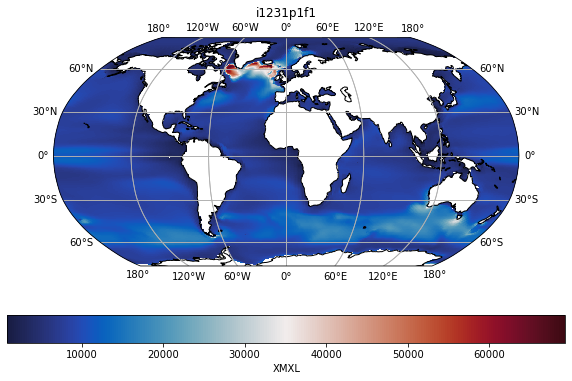

In [13]:
ds_var_1231 = ds_hist_XMXL.XMXL.sel(member_id=['r1i1231p1f1','r2i1231p1f1','r3i1231p1f1','r4i1231p1f1','r5i1231p1f1','r6i1231p1f1','r7i1231p1f1','r8i1231p1f1','r9i1231p1f1','r10i1231p1f1']).mean(dim='time')#.plot()
plt.figure(figsize=(10,6));
ax = plt.axes(projection=ccrs.Robinson());
pc = ds_var_1231.mean(dim='member_id').plot.pcolormesh(ax=ax,
                    transform=ccrs.PlateCarree(),
                    cmap=cmocean.cm.balance,
                    x='TLONG',
                    y='TLAT',
                    #vmin=-3,
                    #vmax=30,
                    cbar_kwargs={'orientation': 'horizontal'})                                    
ax.gridlines(draw_labels=True);
ax.coastlines()
ax.gridlines();
plt.title('i1231p1f1')
del ds_var_1231

### Centralize the South Atlantic 
Need to combine the domain in the east/west direction to centralize the South Atlantic

In [14]:
ilat, flat = 101, 182
ilon1, flon1, ilon2, flon2 = 313, 320, 0, 57
for ifb in range(0,len(fb)):
    print(f'Variable: {fb[ifb]}')
    str=f'sa_ds_{fb[ifb]}=xr.combine_nested([[ds_hist_{fb[ifb]}.isel(nlat = slice(ilat,flat),nlon = slice(ilon1,flon1)),ds_hist_{fb[ifb]}.isel(nlat = slice(ilat,flat),nlon = slice(ilon2,flon2))]],concat_dim=[\'nlat\',\'nlon\'])'
    exec(str)
    str=f'sa_ds_{fb[ifb]}.coords[\'TLONG\'] = (sa_ds_{fb[ifb]}.coords[\'TLONG\'] + 180) % 360 - 180' # change the longitudes: -180 0 180
    exec(str)
    str=f'del ds_hist_{fb[ifb]}'; exec(str)

Variable: TEMP
Variable: SHF
Variable: XMXL


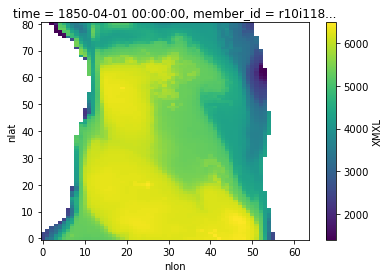

In [15]:
# simple check
sa_ds_XMXL.XMXL.isel(time=2, member_id=0).plot()

In [16]:
sa_ds_XMXL

<xarray.Dataset>
Dimensions:                 (nlon: 64, nlat: 81, moc_comp: 3,
                             transport_comp: 5, transport_reg: 2, z_t: 60,
                             z_t_150m: 15, z_w: 60, z_w_top: 60, z_w_bot: 60,
                             lat_aux_grid: 395, moc_z: 61, time: 1980, d2: 2,
                             member_id: 100)
Coordinates: (12/13)
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid            (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
    ...                      ...
    ULONG                   (nlat, nlon) float64 dask.array<chunksize=(81, 7), meta=np.ndarray>
    ULAT                    (nlat, nlon) float64 dask.array<chunksize=(81, 7), meta=np.ndarray>
    TLONG                   (nlat, nlon) float64 -47.31 -46.19 ... 22.44 23.56
    TLAT                    (nlat, nlon) float64 -25.56 -25.56 ... -1.469 -1.469
  * time                    (time) object 1850-02-01 00:00:00 ... 2015-01-01 ...
  * member_id               (member_id) <U12 'r10i1181p1f1' ... 'r9i1171p1f2'
Dimensions without coordinates: nlon, nlat, moc_comp, transport_comp,
                                transport_reg, d2
Data variables: (12/55)
    moc_components          (nlon, nlat, moc_comp) |S384 dask.array<chunksize=(7, 81, 3), meta=np.ndarray>
    transport_components    (nlon, nlat, transport_comp) |S384 dask.array<chunksize=(7, 81, 5), meta=np.ndarray>
    transport_regions       (nlon, nlat, transport_reg) |S384 dask.array<chunksize=(7, 81, 2), meta=np.ndarray>
    dz                      (nlon, nlat, z_t) float32 dask.array<chunksize=(7, 81, 60), meta=np.ndarray>
    dzw                     (nlon, nlat, z_w) float32 dask.array<chunksize=(7, 81, 60), meta=np.ndarray>
    KMT                     (nlat, nlon) float64 dask.array<chunksize=(81, 7), meta=np.ndarray>
    ...                      ...
    salinity_factor         (nlon, nlat) float64 -0.00347 -0.00347 ... -0.00347
    sflux_factor            (nlon, nlat) float64 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1
    nsurface_t              (nlon, nlat) float64 8.61e+04 8.61e+04 ... 8.61e+04
    nsurface_u              (nlon, nlat) float64 8.297e+04 ... 8.297e+04
    time_bound              (nlon, nlat, time, d2) object dask.array<chunksize=(7, 81, 120, 2), meta=np.ndarray>
    XMXL                    (member_id, time, nlat, nlon) float32 dask.array<chunksize=(1, 120, 81, 7), meta=np.ndarray>

CPU times: user 263 ms, sys: 13 ms, total: 276 ms
Wall time: 631 ms


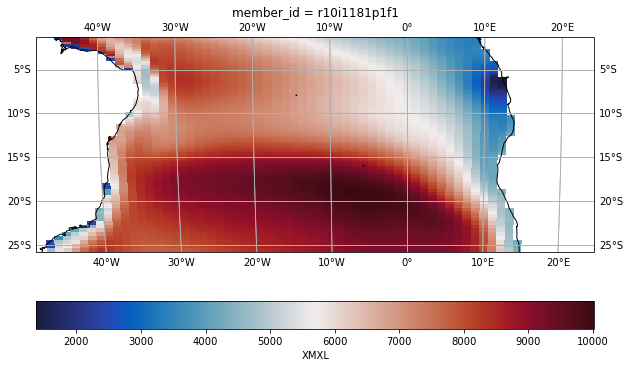

In [17]:
%%time
plt.figure(figsize=(10,6));
ax = plt.axes(projection=ccrs.Robinson());
pc = sa_ds_XMXL.XMXL.isel(member_id=0).mean(dim='time').plot.pcolormesh(ax=ax,
                    transform=ccrs.PlateCarree(),
                    cmap=cmocean.cm.balance,
                    x='TLONG',
                    y='TLAT',
                    #vmin=10,
                    #vmax=30,
                    cbar_kwargs={"orientation": "horizontal"})                                    
ax.gridlines(draw_labels=True);
ax.coastlines()
ax.gridlines();

### Extract correponding area 

In [18]:
area_sa = xr.combine_nested([
    [pop_grid.TAREA.isel(nlat = slice(ilat,flat),nlon = slice(ilon1,flon1)),
     pop_grid.TAREA.isel(nlat = slice(ilat,flat),nlon = slice(ilon2,flon2))]],
    concat_dim=['nlat','nlon']
)

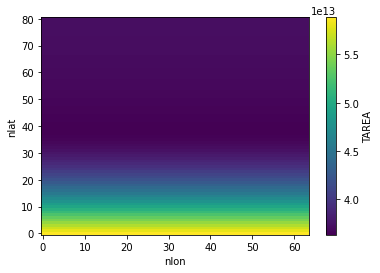

In [19]:
# simple check
area_sa.plot();

### Calculate anomalies
Let's calculate the heat stored from the temperature anomaly field (data minus the average temperature for the whole time series)

In [33]:
# Temperature in degress Kelvin
sa_ds_TEMP_K=sa_ds_TEMP.TEMP+273.15
sa_ds_TEMP_K.coords['z_t']=sa_ds_TEMP_K.coords['z_t']*0.01 # cm to m

In [34]:
sa_ds_TEMP_K_anom=sa_ds_TEMP_K-(sa_ds_TEMP_K.mean('time'))

### Calculte the heat storage:

#### The formula for this is: $$\rm{HS = \uprho_\uptheta~C_p~\int_{z_2}^{z_1}\uptheta_{(z)}'~dz},$$
where:
* HS is heat storage ($\rm{J~m^{-2}}$),
* $\uprho$ is the density of sea water, 1026 $\rm{kg~m^{-3}}$,
* $\rm{C_p}$ is the specific heat of sea water, 3996 $\rm{J~kg^{-1}~K^{-1}}$, do modelo
* $\rm{z}$ is the depth limit o the calculation in meters,
* and $\uptheta$' is the potential temperature monthly anomaly at each depth in degress Kelvin. 

In [35]:
sa_ds_dz=sa_ds_TEMP.dz*0.01 # cm to m
sa_ds_dz.coords['z_t']=sa_ds_dz.coords['z_t']*0.01 # cm to m

<div class="alert alert-block alert-info">
<b>Note:</b> Although most of the variation in heat storage occurs in the first 1000 meters of depth, we will try to add the depth of the AMOC core to this calculation to integrate the temperature up to 1573 m. Ideally, we would compute the heat content in the upper branch of the AMOC, i.e., not use a fixed depth.

In [36]:
sa_ds_TEMP_K_anom.coords['z_t'][51]

<xarray.DataArray 'z_t' ()>
array(3379.7935, dtype=float32)
Coordinates:
    z_t      float32 3.38e+03

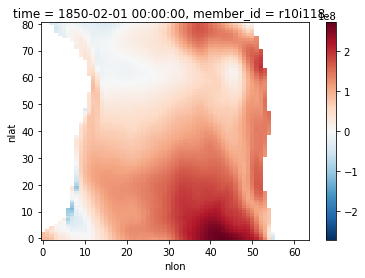

In [37]:
rho = 1026 #kg/m^3
c_p = 3996 #J/(kg K) - I used the same amount of specific heat used by the model
sa_ds_HS=(sa_ds_TEMP_K_anom*sa_ds_dz).sel(z_t=slice(0,43)).sum(dim='z_t')*rho*c_p
sa_ds_HS=sa_ds_HS.where(sa_ds_HS != 0.) # The continents was equal to zero. We replaced zero with NaN, because the ocean heat content will never equal zero. 
sa_ds_HS.isel(member_id=0,time=0).plot()
del sa_ds_TEMP_K; del sa_ds_TEMP_K_anom 

In [38]:
sa_ds_HS= xr.merge([sa_ds_HS.rename('HS')])

In [39]:
# Annual Mean
sa_ds_HS=sa_ds_HS.resample(time='1Y', closed='left').mean('time')
#sa_ds_TEMP=sa_ds_TEMP.resample(time='1Y', closed='left').mean('time')
sa_ds_SHF=sa_ds_SHF.resample(time='1Y', closed='left').mean('time')
#sa_ds_XMXL=sa_ds_XMXL.resample(time='1Y', closed='left').mean('time')

In [ ]:
#del sa_ds_dz; del sa_ds_TEMP; del sa_ds_XMXL

### Perfom computations
Calculate area mean, min, max, and rms for the surface temperature of the selected region

In [40]:
%%time
start="1850-01-01"
end="2014-12-31"
fb=('HS','SHF')
for ifb in range(0,len(fb)):
    print(f'Variable: {fb[ifb]}')
    str=f'var_{fb[ifb]} = sa_ds_{fb[ifb]}.{fb[ifb]}.sel(time=slice(start,end))'
    exec(str)
    print(f'var_{fb[ifb]}')
    # Mean
    str=f'var_mean_{fb[ifb]} = var_{fb[ifb]}.weighted(area_sa).mean(dim=(\'nlon\',\'nlat\')).load()'
    exec(str)
    print(f'var_mean_{fb[ifb]}')
    # Maximum
    str=f'var_max_{fb[ifb]} = var_{fb[ifb]}.max(dim=(\'nlon\',\'nlat\')).load()'
    exec(str)
    print(f'var_max_{fb[ifb]}')
    # Minimum
    str=f'var_min_{fb[ifb]} = var_{fb[ifb]}.min(dim=(\'nlon\',\'nlat\')).load()'
    exec(str)
    print(f'var_min_{fb[ifb]}')
    # RMS
    str=f'var_rms_{fb[ifb]} = rms_da(var_{fb[ifb]}, weights=area_sa, weights_sum=area_sa.sum()).load()'
    exec(str)
    print(f'var_rms_{fb[ifb]}')

Variable: HS
var_HS
var_mean_HS
var_max_HS
var_min_HS
var_rms_HS
Variable: SHF
var_SHF
var_mean_SHF
var_max_SHF
var_min_SHF
var_rms_SHF
CPU times: user 23min 10s, sys: 20.5 s, total: 23min 30s
Wall time: 40min 37s


In [25]:
ds_out_TEMP

<xarray.Dataset>
Dimensions:    (z_t: 60, member_id: 100, time: 165)
Coordinates:
  * z_t        (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * member_id  (member_id) <U12 'r10i1181p1f1' 'r10i1231p1f1' ... 'r9i1171p1f2'
  * time       (time) object 1850-12-31 00:00:00 ... 2014-12-31 00:00:00
Data variables:
    TEMP_rms   (time, member_id, z_t) float64 20.92 20.89 20.86 ... 1.207 0.8128
    TEMP_mean  (time, member_id, z_t) float64 24.47 24.44 24.4 ... 1.857 1.13
    TEMP_max   (time, member_id, z_t) float32 28.05 28.01 28.04 ... 2.95 2.917
    TEMP_min   (time, member_id, z_t) float32 18.89 18.87 18.85 ... -1.0 -1.0
Attributes:
    description:  Heat Storage (TEMP) statistics for the South Atlantic (47.5...
    units:        oC
    author:       Mauricio Rocha
    email:        mauricio.rocha@usp.br

### TODO
Plot some time series to check calculations

### Merge data and save on disk

In [41]:
#units=('J/m2','W/m2','cm','oC')
#fb=('HS','SHF','XMXL','TEMP')
units=('J/m2','W/m2')
fb=('HS','SHF')
#long_name=('Total Surface Heat Flux','Maximum Mixed Layer Depth','Ocean Heat Storage')
long_name=('Heat Storage','Total Surface Heat Flux')
for ifb in range(0,len(fb)):
    print(f'Variable: {fb[ifb]}')
    str=f'ds_out_{fb[ifb]} = xr.merge([var_rms_{fb[ifb]}.rename(\'{fb[ifb]}_rms\'),var_mean_{fb[ifb]}.rename(\'{fb[ifb]}_mean\'),var_max_{fb[ifb]}.rename(\'{fb[ifb]}_max\'),var_min_{fb[ifb]}.rename(\'{fb[ifb]}_min\')])'
    exec(str)
    str=f'ds_out_{fb[ifb]}.attrs[\'description\'] = \'{long_name[ifb]} ({fb[ifb]}) statistics for the South Atlantic (47.5W-23.75E and 25.91623S-1.413613S)\''
    exec(str)
    str=f'ds_out_{fb[ifb]}.attrs[\'units\'] = \'{units[ifb]}\''
    exec(str)
    str=f'ds_out_{fb[ifb]}.attrs[\'author\'] = \'Mauricio Rocha\''
    exec(str)
    str=f'ds_out_{fb[ifb]}.attrs[\'email\'] = \'mauricio.rocha@usp.br\''
    exec(str)

Variable: HS
Variable: SHF


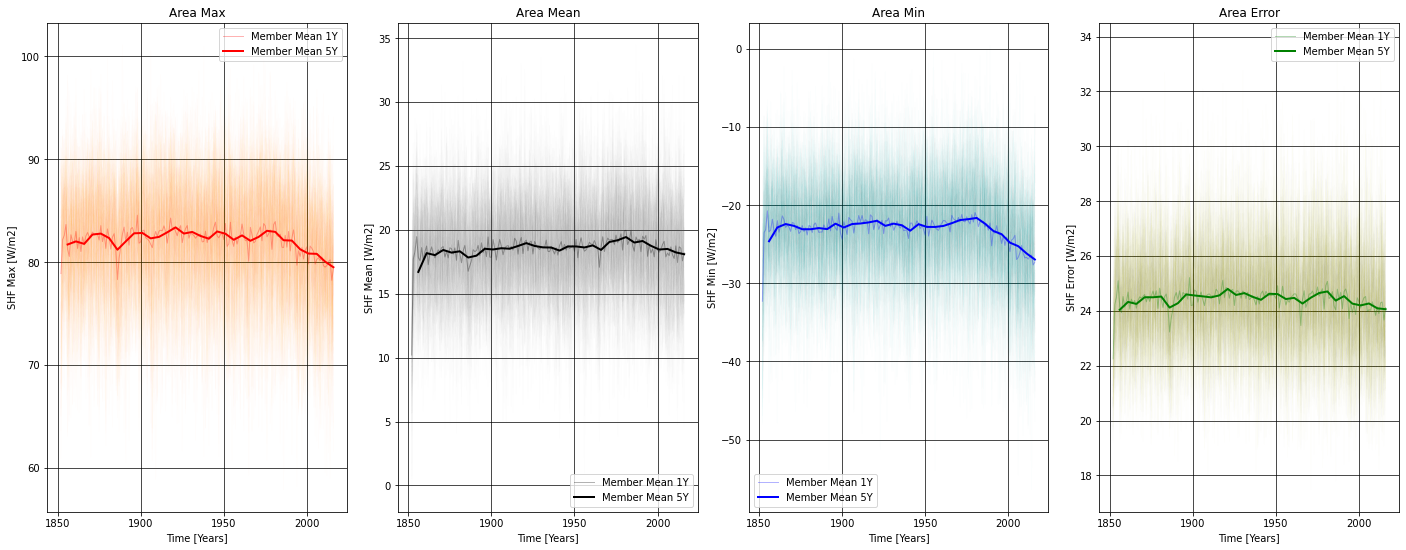

In [42]:
# Total Surface Heat Fux
fig, axes = plt.subplots(1, 4, figsize=(20, 8))
# Maximum
ds_out_SHF.SHF_max.resample(time='1Y', closed='left').mean('time').plot.line(ax=axes[0],x="time",color='orange',alpha=0.01,linewidth=1,add_legend=False)
ds_out_SHF.SHF_max.resample(time='1Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[0],x="time",alpha=0.3,color='r',linewidth=1,label='Member Mean 1Y')
ds_out_SHF.SHF_max.resample(time='5Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[0],x="time",color='r',linewidth=2,label='Member Mean 5Y')
axes[0].set_xlabel('Time [Years]')
axes[0].set_ylabel('SHF Max [W/m2]')
axes[0].set_title('Area Max')
axes[0].grid(color='k', linestyle='-', linewidth=0.7)
axes[0].legend()
#axes[0].set_ylim(103,108.2)
fig.tight_layout(pad=2.0)
# Mean
ds_out_SHF.SHF_mean.resample(time='1Y', closed='left').mean('time').plot.line(ax=axes[1],x="time",color='gray',alpha=0.01,linewidth=1,add_legend=False)
ds_out_SHF.SHF_mean.resample(time='1Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[1],x="time",alpha=0.3,color='k',linewidth=1,label='Member Mean 1Y')
ds_out_SHF.SHF_mean.resample(time='5Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[1],x="time",color='k',linewidth=2,label='Member Mean 5Y')
axes[1].set_xlabel('Time [Years]')
axes[1].set_ylabel('SHF Mean [W/m2]')
axes[1].set_title('Area Mean')
axes[1].grid(color='k', linestyle='-', linewidth=0.7)
axes[1].legend()
#axes[1].set_ylim(17,25.5)
# Minimum
ds_out_SHF.SHF_min.resample(time='1Y', closed='left').mean('time').plot.line(ax=axes[2],x="time",color='c',alpha=0.01,linewidth=1,add_legend=False)
ds_out_SHF.SHF_min.resample(time='1Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[2],x="time",alpha=0.3,color='b',linewidth=1,label='Member Mean 1Y')
ds_out_SHF.SHF_min.resample(time='5Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[2],x="time",color='b',linewidth=2,label='Member Mean 5Y')
axes[2].set_xlabel('Time [Years]')
axes[2].set_ylabel('SHF Min [W/m2]')
axes[2].set_title('Area Min')
axes[2].grid(color='k', linestyle='-', linewidth=0.7)
axes[2].legend()
#axes[2].set_ylim(-63,-51)
# Minimum
ds_out_SHF.SHF_rms.resample(time='1Y', closed='left').mean('time').plot.line(ax=axes[3],x="time",color='y',alpha=0.01,linewidth=1,add_legend=False)
ds_out_SHF.SHF_rms.resample(time='1Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[3],x="time",alpha=0.3,color='g',linewidth=1,label='Member Mean 1Y')
ds_out_SHF.SHF_rms.resample(time='5Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[3],x="time",color='g',linewidth=2,label='Member Mean 5Y')
axes[3].set_xlabel('Time [Years]')
axes[3].set_ylabel('SHF Error [W/m2]')
axes[3].set_title('Area Error')
axes[3].grid(color='k', linestyle='-', linewidth=0.7)
axes[3].legend()
#axes[3].set_ylim(50.3,52)

plt.show()

In [ ]:
# Temperature
fig, axes = plt.subplots(1, 4, figsize=(20, 8))
# Maximum
ds_out_TEMP.TEMP_max.isel(z_t=0).resample(time='1Y', closed='left').mean('time').plot.line(ax=axes[0],x="time",color='orange',alpha=0.01,linewidth=1,add_legend=False)
ds_out_TEMP.TEMP_max.isel(z_t=0).resample(time='1Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[0],x="time",alpha=0.3,color='r',linewidth=1,label='Member Mean 1Y -5m')
ds_out_TEMP.TEMP_max.isel(z_t=0).resample(time='5Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[0],x="time",color='r',linewidth=2,label='Member Mean 5Y -5m')
axes[0].set_xlabel('Time [Years]')
axes[0].set_ylabel('TEMP Max [oC]')
axes[0].set_title('Area Max')
axes[0].grid(color='k', linestyle='-', linewidth=0.7)
axes[0].legend()
#axes[0].set_ylim(28.78,30.015)
fig.tight_layout(pad=2.0)
# Mean
ds_out_TEMP.TEMP_mean.isel(z_t=0).resample(time='1Y', closed='left').mean('time').plot.line(ax=axes[1],x="time",color='gray',alpha=0.01,linewidth=1,add_legend=False)
ds_out_TEMP.TEMP_mean.isel(z_t=0).resample(time='1Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[1],x="time",alpha=0.3,color='k',linewidth=1,label='Member Mean 1Y -5m')
ds_out_TEMP.TEMP_mean.isel(z_t=0).resample(time='5Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[1],x="time",color='k',linewidth=2,label='Member Mean 5Y -5m')
axes[1].set_xlabel('Time [Years]')
axes[1].set_ylabel('TEMP Mean [oC]')
axes[1].set_title('Area Mean')
axes[1].grid(color='k', linestyle='-', linewidth=0.7)
axes[1].legend()
#axes[1].set_ylim(25.7,26.7)
# Minimum
ds_out_TEMP.TEMP_min.isel(z_t=0).resample(time='1Y', closed='left').mean('time').plot.line(ax=axes[2],x="time",color='c',alpha=0.01,linewidth=1,add_legend=False)
ds_out_TEMP.TEMP_min.isel(z_t=0).resample(time='1Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[2],x="time",alpha=0.3,color='b',linewidth=1,label='Member Mean 1Y -5m')
ds_out_TEMP.TEMP_min.isel(z_t=0).resample(time='5Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[2],x="time",color='b',linewidth=2,label='Member Mean 5Y -5m')
axes[2].set_xlabel('Time [Years]')
axes[2].set_ylabel('TEMP Min [oC]')
axes[2].set_title('Area Min')
axes[2].grid(color='k', linestyle='-', linewidth=0.7)
axes[2].legend()
#axes[2].set_ylim(20.7,21.7)
# Minimum
ds_out_TEMP.TEMP_rms.isel(z_t=0).resample(time='1Y', closed='left').mean('time').plot.line(ax=axes[3],x="time",color='y',alpha=0.01,linewidth=1,add_legend=False)
ds_out_TEMP.TEMP_rms.isel(z_t=0).resample(time='1Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[3],x="time",alpha=0.3,color='g',linewidth=1,label='Member Mean 1Y -5m')
ds_out_TEMP.TEMP_rms.isel(z_t=0).resample(time='5Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[3],x="time",color='g',linewidth=2,label='Member Mean 5Y -5m')
axes[3].set_xlabel('Time [Years]')
axes[3].set_ylabel('TEMP Error [oC]')
axes[3].set_title('Area Error')
axes[3].grid(color='k', linestyle='-', linewidth=0.7)
axes[3].legend()
#axes[3].set_ylim(19.4,20.2)

plt.show()

In [ ]:
# Temperature
fig, axes = plt.subplots(1, 4, figsize=(20, 8))
# Maximum
ds_out_TEMP.TEMP_max.isel(z_t=40).resample(time='1Y', closed='left').mean('time').plot.line(ax=axes[0],x="time",color='orange',alpha=0.1,linewidth=1,add_legend=False)
ds_out_TEMP.TEMP_max.isel(z_t=40).resample(time='1Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[0],x="time",alpha=0.6,color='r',linewidth=1,label='Member Mean 1Y -1106m')
ds_out_TEMP.TEMP_max.isel(z_t=40).resample(time='5Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[0],x="time",color='r',linewidth=2,label='Member Mean 5Y -1106m')
axes[0].set_xlabel('Time [Years]')
axes[0].set_ylabel('TEMP Max [oC]')
axes[0].set_title('Area Max')
axes[0].grid(color='k', linestyle='-', linewidth=0.7)
axes[0].legend()
#axes[0].set_ylim(28.78,30.015)
fig.tight_layout(pad=2.0)
# Mean
ds_out_TEMP.TEMP_mean.isel(z_t=40).resample(time='1Y', closed='left').mean('time').plot.line(ax=axes[1],x="time",color='gray',alpha=0.1,linewidth=1,add_legend=False)
ds_out_TEMP.TEMP_mean.isel(z_t=40).resample(time='1Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[1],x="time",alpha=0.6,color='k',linewidth=1,label='Member Mean 1Y -1106m')
ds_out_TEMP.TEMP_mean.isel(z_t=40).resample(time='5Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[1],x="time",color='k',linewidth=2,label='Member Mean 5Y -1106m')
axes[1].set_xlabel('Time [Years]')
axes[1].set_ylabel('TEMP Mean [oC]')
axes[1].set_title('Area Mean')
axes[1].grid(color='k', linestyle='-', linewidth=0.7)
axes[1].legend()
#axes[1].set_ylim(25.7,26.7)
# Minimum
ds_out_TEMP.TEMP_min.isel(z_t=40).resample(time='1Y', closed='left').mean('time').plot.line(ax=axes[2],x="time",color='c',alpha=0.1,linewidth=1,add_legend=False)
ds_out_TEMP.TEMP_min.isel(z_t=40).resample(time='1Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[2],x="time",alpha=0.6,color='b',linewidth=1,label='Member Mean 1Y -1106m')
ds_out_TEMP.TEMP_min.isel(z_t=40).resample(time='5Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[2],x="time",color='b',linewidth=2,label='Member Mean 5Y -1106m')
axes[2].set_xlabel('Time [Years]')
axes[2].set_ylabel('TEMP Min [oC]')
axes[2].set_title('Area Min')
axes[2].grid(color='k', linestyle='-', linewidth=0.7)
axes[2].legend()
#axes[2].set_ylim(20.7,21.7)
# Minimum
ds_out_TEMP.TEMP_rms.isel(z_t=40).resample(time='1Y', closed='left').mean('time').plot.line(ax=axes[3],x="time",color='y',alpha=0.1,linewidth=1,add_legend=False)
ds_out_TEMP.TEMP_rms.isel(z_t=40).resample(time='1Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[3],x="time",alpha=0.6,color='g',linewidth=1,label='Member Mean 1Y -1106m')
ds_out_TEMP.TEMP_rms.isel(z_t=40).resample(time='5Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[3],x="time",color='g',linewidth=2,label='Member Mean 5Y -1106m')
axes[3].set_xlabel('Time [Years]')
axes[3].set_ylabel('TEMP Error [oC]')
axes[3].set_title('Area Error')
axes[3].grid(color='k', linestyle='-', linewidth=0.7)
axes[3].legend()
#axes[3].set_ylim(19.4,20.2)

plt.show()

In [ ]:
# Maximum mixed layer depth
fig, axes = plt.subplots(1, 4, figsize=(20, 8))
# Maximum
(ds_out_XMXL.XMXL_max.resample(time='1Y', closed='left').mean('time')*-0.01).plot.line(ax=axes[0],x="time",color='orange',alpha=0.01,linewidth=1,add_legend=False)
(ds_out_XMXL.XMXL_max.resample(time='1Y', closed='left').mean('time').mean('member_id')*-0.01).plot.line(ax=axes[0],x="time",alpha=0.3,color='r',linewidth=1,label='Member Mean 1Y')
(ds_out_XMXL.XMXL_max.resample(time='5Y', closed='left').mean('time').mean('member_id')*-0.01).plot.line(ax=axes[0],x="time",color='r',linewidth=2,label='Member Mean 5Y')
axes[0].set_xlabel('Time [Years]')
axes[0].set_ylabel('XMXL Max [m]')
axes[0].set_title('Area Max')
axes[0].grid(color='k', linestyle='-', linewidth=0.7)
axes[0].legend()
#axes[0].set_ylim(103,108.2)
fig.tight_layout(pad=2.5)
# Mean
(ds_out_XMXL.XMXL_mean.resample(time='1Y', closed='left').mean('time')*-0.01).plot.line(ax=axes[1],x="time",color='gray',alpha=0.01,linewidth=1,add_legend=False)
(ds_out_XMXL.XMXL_mean.resample(time='1Y', closed='left').mean('time').mean('member_id')*-0.01).plot.line(ax=axes[1],x="time",alpha=0.3,color='k',linewidth=1,label='Member Mean 1Y')
(ds_out_XMXL.XMXL_mean.resample(time='5Y', closed='left').mean('time').mean('member_id')*-0.01).plot.line(ax=axes[1],x="time",color='k',linewidth=2,label='Member Mean 5Y')
axes[1].set_xlabel('Time [Years]')
axes[1].set_ylabel('XMXL Mean [m]')
axes[1].set_title('Area Mean')
axes[1].grid(color='k', linestyle='-', linewidth=0.7)
axes[1].legend()
#axes[1].set_ylim(17,25.5)
# Minimum
(ds_out_XMXL.XMXL_min.resample(time='1Y', closed='left').mean('time')*-0.01).plot.line(ax=axes[2],x="time",color='c',alpha=0.01,linewidth=1,add_legend=False)
(ds_out_XMXL.XMXL_min.resample(time='1Y', closed='left').mean('time').mean('member_id')*-0.01).plot.line(ax=axes[2],x="time",alpha=0.3,color='b',linewidth=1,label='Member Mean 1Y')
(ds_out_XMXL.XMXL_min.resample(time='5Y', closed='left').mean('time').mean('member_id')*-0.01).plot.line(ax=axes[2],x="time",color='b',linewidth=2,label='Member Mean 5Y')
axes[2].set_xlabel('Time [Years]')
axes[2].set_ylabel('XMXL Min [m]')
axes[2].set_title('Area Min')
axes[2].grid(color='k', linestyle='-', linewidth=0.7)
axes[2].legend()
#axes[2].set_ylim(-63,-51)
# Minimum
(ds_out_XMXL.XMXL_rms.resample(time='1Y', closed='left').mean('time')*-0.01).plot.line(ax=axes[3],x="time",color='y',alpha=0.01,linewidth=1,add_legend=False)
(ds_out_XMXL.XMXL_rms.resample(time='1Y', closed='left').mean('time').mean('member_id')*-0.01).plot.line(ax=axes[3],x="time",alpha=0.3,color='g',linewidth=1,label='Member Mean 1Y')
(ds_out_XMXL.XMXL_rms.resample(time='5Y', closed='left').mean('time').mean('member_id')*-0.01).plot.line(ax=axes[3],x="time",color='g',linewidth=2,label='Member Mean 5Y')
axes[3].set_xlabel('Time [Years]')
axes[3].set_ylabel('XMXL Error [m]')
axes[3].set_title('Area Error')
axes[3].grid(color='k', linestyle='-', linewidth=0.7)
axes[3].legend()
#axes[3].set_ylim(50.3,52)

plt.show()

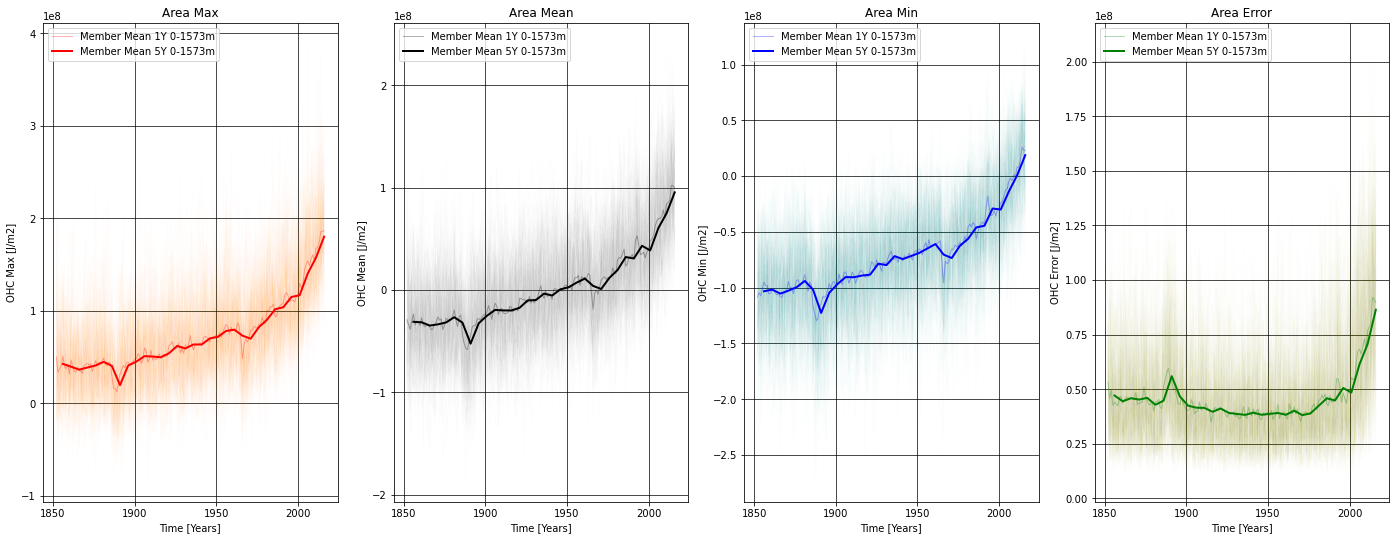

In [43]:
# Heat Strage
fig, axes = plt.subplots(1, 4, figsize=(20, 8))
# Maximum
ds_out_HS.HS_max.resample(time='1Y', closed='left').mean('time').plot.line(ax=axes[0],x="time",color='orange',alpha=0.01,linewidth=1,add_legend=False)
ds_out_HS.HS_max.resample(time='1Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[0],x="time",alpha=0.3,color='r',linewidth=1,label='Member Mean 1Y 0-1573m')
ds_out_HS.HS_max.resample(time='5Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[0],x="time",color='r',linewidth=2,label='Member Mean 5Y 0-1573m')
axes[0].set_xlabel('Time [Years]')
axes[0].set_ylabel('OHC Max [J/m2]')
axes[0].set_title('Area Max')
axes[0].grid(color='k', linestyle='-', linewidth=0.7)
axes[0].legend()
#axes[0].set_ylim(103,108.2)
fig.tight_layout(pad=2.5)
# Mean
ds_out_HS.HS_mean.resample(time='1Y', closed='left').mean('time').plot.line(ax=axes[1],x="time",color='gray',alpha=0.01,linewidth=1,add_legend=False)
ds_out_HS.HS_mean.resample(time='1Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[1],x="time",alpha=0.3,color='k',linewidth=1,label='Member Mean 1Y 0-1573m')
ds_out_HS.HS_mean.resample(time='5Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[1],x="time",color='k',linewidth=2,label='Member Mean 5Y 0-1573m')
axes[1].set_xlabel('Time [Years]')
axes[1].set_ylabel('OHC Mean [J/m2]')
axes[1].set_title('Area Mean')
axes[1].grid(color='k', linestyle='-', linewidth=0.7)
axes[1].legend()
#axes[1].set_ylim(17,25.5)
# Minimum
ds_out_HS.HS_min.resample(time='1Y', closed='left').mean('time').plot.line(ax=axes[2],x="time",color='c',alpha=0.01,linewidth=1,add_legend=False)
ds_out_HS.HS_min.resample(time='1Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[2],x="time",alpha=0.3,color='b',linewidth=1,label='Member Mean 1Y 0-1573m')
ds_out_HS.HS_min.resample(time='5Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[2],x="time",color='b',linewidth=2,label='Member Mean 5Y 0-1573m')
axes[2].set_xlabel('Time [Years]')
axes[2].set_ylabel('OHC Min [J/m2]')
axes[2].set_title('Area Min')
axes[2].grid(color='k', linestyle='-', linewidth=0.7)
axes[2].legend()
#axes[2].set_ylim(-63,-51)
# Minimum
ds_out_HS.HS_rms.resample(time='1Y', closed='left').mean('time').plot.line(ax=axes[3],x="time",color='y',alpha=0.01,linewidth=1,add_legend=False)
ds_out_HS.HS_rms.resample(time='1Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[3],x="time",alpha=0.3,color='g',linewidth=1,label='Member Mean 1Y 0-1573m')
ds_out_HS.HS_rms.resample(time='5Y', closed='left').mean('time').mean('member_id').plot.line(ax=axes[3],x="time",color='g',linewidth=2,label='Member Mean 5Y 0-1573m')
axes[3].set_xlabel('Time [Years]')
axes[3].set_ylabel('OHC Error [J/m2]')
axes[3].set_title('Area Error')
axes[3].grid(color='k', linestyle='-', linewidth=0.7)
axes[3].legend()
#axes[3].set_ylim(50.3,52)

plt.show()

### Let's save the data in netcdf format

In [45]:
# create a directory on scratch to save the output
#for ifb in range(0,len(fb)):
print(f'Variable: {fb[1]}')
str=f'path = \'/glade/scratch/mauricio/LENS2_historical_south_atlantic/{fb[1]}/\'.format(getpass.getuser())'
exec(str)
str=f'os.system(\'mkdir -p \'+path)'
exec(str)
str=f'ds_out_{fb[1]}.to_netcdf(path+\'{fb[1]}_stats.nc\')'
exec(str)

Variable: SHF


In [43]:
ds_out_TEMP.to_netcdf('/glade/scratch/mauricio/LENS2_historical_south_atlantic/TEMP/TEMP_stats.nc')

In [ ]:
cluster.close()
client.close()